In [1]:
using Plots, DifferentialEquations, Distributions, Random, LaTeXStrings, DataFrames, GLM, JLD2, FileIO, StatsPlots, LinearAlgebra, PyCall, QuadGK, Interpolations

In [2]:
σ = [1e-3,1e-2,1e-1,0.25,0.5];
i = 1;
# components of n_load correspond to exactly the simulations done with that component of sigma

In [15]:
function CR!(dx,x,p,t)
    N,M,R = p
    dx[1:N] = x[1:N].*(R*x[1+N:N+M])
    dx[N+1:N+M] = -x[1+N:N+M].*(transpose(R)*x[1:N])   
end

function random_mat_uniform(N,M,σ)
    a = rand(Uniform(1-σ,1+σ),N,M);
    return a 
end

function random_mat_uniform_sparse(N,M,σ,S)
    a = rand(Uniform(1-σ,1+σ),N,M);
    for i in 1:N, j in 1:M
        r = rand()
        if r < S
            global a[i,j] = 0
        end
    end
    return a 
end

function finds(N,M,R,D,Ymag,steps,tspanf)

    X0s = Array{Any}(undef,steps+1);
    Y0s = Array{Any}(undef,steps+1);
    sol_mat = Matrix{Float64}[];
    res_mat = Matrix{Float64}[];
    X0s[1] = ones(N)/N*(D-1);
    X0s[1] ./= D
    Y0s[1] = Ymag

    p = [N,M,R]
    tspan = (0.,tspanf)

    for j in 1:steps

        X0 = X0s[j]
        Y0 = Y0s[j]
        XY0 = vcat(X0,Y0)
        prob = ODEProblem(CR!, XY0, tspan, p)
        sol_tmp = solve(prob,Tsit5(),abstol=1e-12,reltol=1e-12)

        X0s[j+1] = sol_tmp.u[length(sol_tmp.u)][1:p[1]]./D
        Y0s[j+1] = sol_tmp.u[length(sol_tmp.u)][(p[1]+1):(p[1]+M)]./D .+ Y0s[1]
        
        sol = [sol_tmp.u[i][1:p[1]] for i in 1:length(sol_tmp.u)]   
        res = [sol_tmp.u[i][(p[1]+1):(p[1]+M)] for i in 1:length(sol_tmp.u)]

        tmp = zeros(length(sol),p[1])
        for i in 1:length(sol)
            tmp[i,:] = sol[i]
        end
        push!(sol_mat,tmp)

        tmp_res = zeros(length(res),M)
        for i in 1:length(res)
            tmp_res[i,:] = res[i]
        end
        push!(res_mat,tmp_res)
        
        # print("dilution step number $j done\n")
    end

    return sol_mat,res_mat

end

finds (generic function with 1 method)

In [16]:
N = 100;
M = 100;
D = 100;
steps = 2000;
Ymag = ones(M)*100;
Ymag ./= sum(Ymag);
tspanf = 8;
σ = 0.001;

In [17]:
R = random_mat_uniform_sparse(N,M,σ,0.1)
R1 = random_mat_uniform(N,M,σ)
n_sparse,r_sparse = finds(N,M,R,D,Ymag,steps,tspanf);
n,r = finds(N,M,R1,D,Ymag,steps,tspanf);

In [59]:
plot([round(sum(n_load[i][end,:]),digits=3) for i in 10:length(n_load)],label=L"\sigma = 0.5",size=(800,500),ylim=(-0.7,2),ylabel=L"\sum_{i=1}^S X_{i,j}(T)",
     title="Total final species abundance in each dil.step",xlabel="Dilution steps (j)",thickness_scaling=1.2)
# this represents how the final total abundance at each dilution step is changing, it looks like it's almost constant
# savefig("species_ab_final_s6_nonsparse.png")

In [21]:
# DENSE 
xi_load = [n[i]./sum(n[i],dims=2) for i in 1:length(n)]
m = Matrix{Float64}(undef,length(n),100)

for i in 1:length(n)
    m[i,:] = xi_load[i][end,:] 
end

In [26]:
# SPARSE 
xi_load_sparse = [n_sparse[i]./sum(n_sparse[i],dims=2) for i in 1:length(n_sparse)]
m_sparse = Matrix{Float64}(undef,length(n_sparse),100)

for i in 1:length(n_sparse)
    m_sparse[i,:] = xi_load_sparse[i][end,:] 
end

In [29]:
# goodind = [i for i in 1:100 if i ∉ findall(m[end,:] .== 0)];
plot(m_sparse,legend=false,size=(800,500),color=:blues,line_z=m_sparse,xlabel="Dilution steps (j)",ylabel=L"\frac{X_{i,j}(T)}{\sum_{i}X_{i,j}(T)}",
     thickness_scaling=1.6)
annotate!(1500,0.65,text(L"\sigma=10^{-3}",12))
# savefig("frequencies_sparse_s1.png")

#### Invasion analysis and log rates

In [9]:
N = size(n_load[end],2);
M = size(r_load[end],2);
steps = length(n_load)
steps_vector = collect(1:steps-1)
decrease_rates = Matrix{Float64}(undef,steps-1,N);
log_final_abd = Matrix{Float64}(undef,steps-1,N);

In [25]:
for i in 1:steps-1
    decrease_rates[i,:] = log.((n_load[i+1][end,:])) - log.(n_load[i][end,:])
    log_final_abd[i,:] = log.(n_load[i][end,:])
end

In [23]:
n_load = n
r_load = r
N = size(n_load[end],2);
M = size(r_load[end],2);
decrease_rates = Matrix{Float64}(undef,1,N);
log_final_abd = Matrix{Float64}(undef,1,N);
decrease_rates[1,:] = log.((n_load[2][end,:])) - log.(n_load[1][end,:]);
log_final_abd[1,:] = log.(n_load[1][end,:]);

In [688]:
# plot(steps_vector,decrease_rates,legend=false,size=(800,500),color=:blues,line_z=decrease_rates,ylabel=L"\log X_{i,j+1}(T) - \log X_{i,j}(T)",xlabel="Dilution steps",thickness_scaling=1.2)
# hline!([0],linestyle=:dash,color=:black)#,ylim=(-1e-4,1.2e-4))

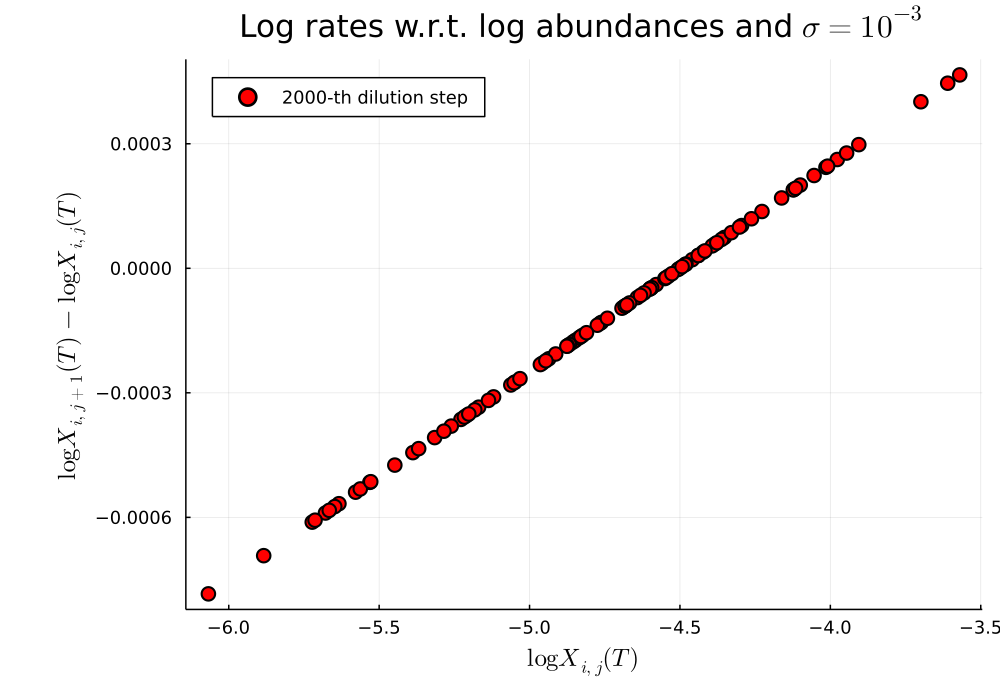

In [33]:
# i = 1 # i want to see a kind of a gif 
# aa = findall(log_final_abd[end,:] .!= -Inf);
scatter(log_final_abd[end,:],decrease_rates[end,:],label="2000-th dilution step",size=(1000,700),markersize=5,
        ylabel=L"\log X_{i,j+1}(T) - \log X_{i,j}(T)",xlabel = L"\log X_{i,j}(T)",thickness_scaling=1.5,legend=:topleft,
        title="Log rates w.r.t. log abundances and "*L"\sigma=10^{-3}",color=:red)
# scatter!(log_final_abd[10,:],decrease_rates[10,:],label="10-th dilution step",markersize=5)
# scatter!(log_final_abd[100,:],decrease_rates[100,:],label="100-th dilution step",markersize=5)
# scatter!(log_final_abd[300,:],decrease_rates[300,:],label="300-th dilution step",markersize=5)
# scatter!(log_final_abd[400,:],decrease_rates[400,:],label="600-th dilution step",markersize=5)
# scatter!(log_final_abd[end,:],decrease_rates[end,:],label="2000-th dilution step",markersize=5)

# savefig("logrates_s6.png")

#### Invasion analysis for non sparse consumption matrix simulations

In [34]:
n_ex = n_load[end];
positive_decrease_rates = findall(decrease_rates[end,:] .>= 0);
negative_decrease_rates = findall(decrease_rates[end,:] .< 0);

# first_positive_decrease_rates_index = findall(n_ex[end,:] .== minimum(n_ex[end,positive_decrease_rates]));
first_negative_decrease_rates_index = findall(n_ex[end,:] .== sort(n_ex[end,negative_decrease_rates],rev=true)[1]);
good_indices = vcat(positive_decrease_rates,first_negative_decrease_rates_index);

In [82]:
# aa = findall(log_final_abd[end,:] .!= -Inf);
scatter(log_final_abd[end,good_indices],decrease_rates[end,good_indices],label=L"X_{i,j+1}(T)/X_{i,j}(T) > 0",size=(1000,700),markersize=5,
        ylabel=L"\log X_{i,j+1}(T) - \log X_{i,j}(T)",xlabel = L"\log X_{i,j}(T)",thickness_scaling=1.6,legend=:topleft,color=:red,ylim=(-0.0001,0.0002),xlim=(-5,-4))
scatter!([log_final_abd[end,54]],[decrease_rates[end,54]],color=:black,markersize=10,label=L"X_{1st,j+1}(T)/X_{1st,j}(T) < 0")
scatter!(log_final_abd[end,[i for i in 1:100 if i ∉ good_indices]],decrease_rates[end,[i for i in 1:100 if i ∉ good_indices]],label=L"X_{i,j+1}(T)/X_{i,j}(T) < 0",color=:gray)
plot!([-4.75,log_final_abd[end,54]-0.02],[0.0001,decrease_rates[end,54]+0.00001],arrow=true,label="",color=:black)
savefig("first_neg_decrease_rate.png")

In [85]:
plot(n_ex[:,positive_decrease_rates],colorbar=:none,size=(800,500),ylabel=L"X_i(t)",xlabel="Time steps (t)",color=:blues,line_z=n_ex[:,positive_decrease_rates],
     linewidth=1,label="",legend=:topleft,thickness_scaling=1.6)
plot!(n_ex[:,first_negative_decrease_rates_index],label=L"X_{1st,j+1}(T)/X_{1st,j}(T) < 0",color=:black,linewidth=3,linestyle=:dash)
savefig("example_invasion.png")

In [750]:
function CR!(dx,x,p,t)
    N,M,R = p
    dx[1:N] = x[1:N].*(R*x[1+N:N+M])
    dx[N+1:N+M] = -x[1+N:N+M].*(transpose(R)*x[1:N])   
end

CR! (generic function with 1 method)

In [827]:
N = length(good_indices); 
M = 100;
D = 100;
tspanf = 12;
Ymag = ones(M)*1000;
Ymag ./= sum(Ymag) 
new_R_load = vcat(R_load[positive_decrease_rates,:],R_load[first_negative_decrease_rates_index,:])
# new_R_load = R_load[index_max_abd,:]
tspan = (0.,tspanf)
sol_mat = n_ex[:,good_indices];

p = [N,M,new_R_load];

In [289]:
# i = 0
# # while xor(isapprox(round(sum(res[1])),round(sol_mat[end,1]);atol=1e-1),true)
# for i in 1:100
#     X0 = [sol_mat[end,1:N-1]./D...,0]; 
#     Y0 = r_load[end][end,:]./D + Ymag 
#     XY0 = vcat(X0,Y0);

#     prob = ODEProblem(CR!, XY0, tspan, p)
#     sol_tmp = solve(prob,Tsit5(),abstol=1e-8,reltol=1e-8)
#     sol = [sol_tmp.u[i][1:p[1]] for i in 1:length(sol_tmp.u)];
#     res = [sol_tmp.u[i][(p[1]+1):(p[1]+M)] for i in 1:length(sol_tmp.u)];
#     sol_mat = zeros(length(sol),p[1])
#     for i in 1:length(sol)
#         sol_mat[i,:] = sol[i]
#     end
#     # i += 1
#     # print(i)
# end

In [828]:
# INVASION ANALYSIS 
X0 = [sol_mat[end,1:N-1]/D...,1e-20]; 
# i'm changing the abundance of the second most abundant species in the environment to a very small one. 
# we want to see whether the latter is gonna manage to invade the system, that is if its growth rate after one step of evolution is greater or less than D
Y0 = r_load[end][end,:]./D + Ymag 
XY0 = vcat(X0,Y0);

prob = ODEProblem(CR!, XY0, tspan, p)
sol_tmp = solve(prob,Tsit5(),abstol=1e-8,reltol=1e-8)
sol = [sol_tmp.u[i][1:p[1]] for i in 1:length(sol_tmp.u)];
res = [sol_tmp.u[i][(p[1]+1):(p[1]+M)] for i in 1:length(sol_tmp.u)];
sol_mat = zeros(length(sol),p[1])
for i in 1:length(sol)
    sol_mat[i,:] = sol[i]
end

In [829]:
inv = ones(length(positive_decrease_rates));
if sol_mat[end,end]./sol_mat[1,end] > D 
    push!(inv,1);
    print("First invasion success")
else
    push!(inv,0);
end 

First invasion success

In [758]:
# IF INVASION HAPPENS, SPECIES GROWTH RATE IS GREATER THAN D, MAYBE THERE IS THE POSSIBILITY THAT ALSO THE SPECIES WHOSE ABUNDANCE IS 
# SMALLER THAN THE PREVIOUS ONE AND HAS A NEGATIVE DECREASE RATE CAN INVADE. WE CAN REPEAT THE PROCESS UNTIL ALL THE SPECIES INVADE OR 
# WE FIND ONE THAT IS NOT ABLE TO GET INTO THE SYSTEM

di = sort(Dict(n_ex[end,negative_decrease_rates] .=> negative_decrease_rates), by = x -> x[1], rev=true)

# from now on we should introduce into the poll of species those that are into the positive_decrease_rates_indices and each of those that are into the ordered
# dictionaty. It represents species whose decrease rate is negative and ordered in terms of their abundances. Including them into the poll of the above 
# mentioned species should start from the second element of the dictionary when the first is able to INVADE the system

negative_decrease_rates_ordered = [values(di)...][2:end];

In [759]:
# now repeat as long as we finish the components of "negative_decrease_rates_ordered" the invasion analysis 
for i in 1:(length(negative_decrease_rates_ordered)-1)
    push!(good_indices,negative_decrease_rates_ordered[i])

    N = length(good_indices); 
    M = 100;
    D = 100;
    tspanf = 12;
    Ymag = ones(M)*1000;
    Ymag ./= sum(Ymag) 
    new_R_load = R_load[good_indices,:]
    tspan = (0.,tspanf)
    sol_mat = n_ex[:,good_indices];
    p = [N,M,new_R_load];

    X0 = [sol_mat[end,1:N-1]/D...,1e-20]; 
    Y0 = r_load[end][end,:]./D + Ymag 
    XY0 = vcat(X0,Y0);

    prob = ODEProblem(CR!, XY0, tspan, p)
    sol_tmp = solve(prob,Tsit5(),abstol=1e-8,reltol=1e-8)
    sol = [sol_tmp.u[i][1:p[1]] for i in 1:length(sol_tmp.u)];
    res = [sol_tmp.u[i][(p[1]+1):(p[1]+M)] for i in 1:length(sol_tmp.u)];
    sol_mat = zeros(length(sol),p[1])
    for i in 1:length(sol)
        sol_mat[i,:] = sol[i]
    end

    if sol_mat[end,end]./sol_mat[1,end] > D 
        push!(inv,1)
    else
        push!(inv,0)
    end 
end

In [762]:
sum(inv)

5.0